#### Task 2 Encoding and Classifier

* Encoding the following files in a quantum circuit mock_train_set.csv and mock_test_set.csv in at least two different ways (these could basis, angle,  amplitude, kernel or random encoding).
* Design a variational quantum circuit for each of the encodings, uses the column 4  as the target,  this is a binary class 0 and 1.
* You must  use the data  from column0 to column3 for your proposed classifier. 
* Consider the ansatz you are going to design as a layer and find out how many layers are necessary to reach the best performance.

Analyze and discuss the results.

Feel free to use existing frameworks (e.g. PennyLane, Qiskit) for creating and training the circuits.

For the variational circuit, you can try any circuit you want. You can start from one with a layer of RX, RZ and CNOTs.

---

I started by looking into each of the suggested encoding schemes to determine the best choices for our problem. A 2020 paper[[1]](#1) discusses various encoding methods.

* **Basis encoding**: Represent data as binary numbers and map into Hilbert space. This encoding is not a good choice as it would cause large circuit width for our dataset.

* **Amplitude encoding**: Requires log2(n) qubits for n-dimensional data. => We would only need log2(4)=2 qubits. Amplitude encoding has the disadvantage that it is harder to construct than angle encoding.

* **Angle encoding**: The classical features are encoded into the rotational angle of the qubit. Requires n qubits for n-dimensional data. Angle encodings can be constructed with only a single rotation normalized to be in the interval [-π,π]. Dense angle encoding uses only n/2 qubits by exploiting the relative phase (uses a phase gate after the rotation gate).

Based on this, I decided to complete the problem with the amplitude encoding, the angle encoding, and the dense angle encoding.

<a id="1">[1]</a>. Ryan LaRose and Brian Coyle, *Robust data encodings for quantum classifiers*, 2020. (https://arxiv.org/pdf/2003.01695.pdf)

---

The first step is to load in and look at the data to spot any patterns. Then the data can be preprocessed before we move on to encoding and classification. 

Raw data before preprocessing:



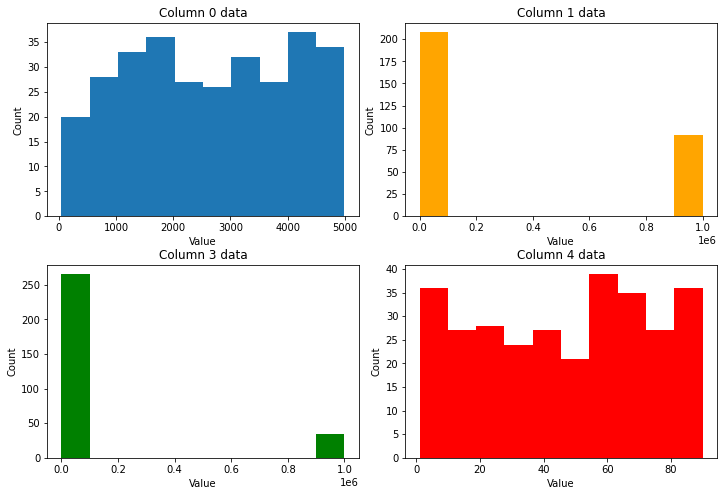

In [100]:
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)

dev = qml.device("default.qubit", wires=2)

train_set = np.loadtxt(open("mock_train_set.csv"), delimiter=",")
test_set = np.loadtxt(open("mock_test_set.csv"), delimiter=",")

print("Raw data before preprocessing:\n")
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.subplots_adjust(hspace=0.25, wspace=0.15)
axs[0, 0].hist(train_set[1:,0], density=False, bins=10) 
axs[0, 0].set_title('Column 0 data')
axs[0, 1].hist(train_set[1:,1], density=False, bins=10, color = "orange") 
axs[0, 1].set_title('Column 1 data')
axs[1, 0].hist(train_set[1:,2], density=False, bins=10, color = "green") 
axs[1, 0].set_title('Column 3 data')
axs[1, 1].hist(train_set[1:,3], density=False, bins=10, color = "red") 
axs[1, 1].set_title('Column 4 data')
for ax in axs.flat:
    ax.set(xlabel='Value', ylabel='Count')
plt.show()

The data in the second and third columns is difficult to interpret due to the huge range of the values. I decided to preprocess the data in the following way: the first column was divided by 1000 so it does not dominate the training by putting it on roughly the same order of magnitude as the other features. The log of the second and third columns was taken so their values would also be within a more reasonable range. Since the fourth column had values between 0 and 90, it appeared to be angles, so the sin was taken of this column. The last column, the labels, was changed from 0 and 1 to -1 and 1 to help with classification, as the expectation value of the Pauli Z taken later will output values between -1 and 1.

Data after preprocessing:



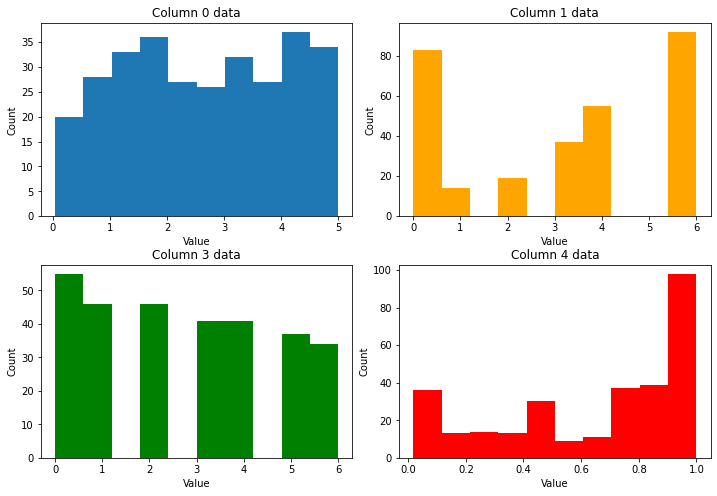

In [101]:
def preprocessing(data):
    data[1:,0] = data[1:,0] / 1000
    data[1:,1] = np.log10(data[1:,1])
    data[1:,2] = np.log10(data[1:,2])
    data[1:,3] = np.sin(data[1:,3]*np.pi/180)
    data[1:,4] = 2 * data[1:,4] - 1
    return data

train_set = preprocessing(train_set)
test_set = preprocessing(test_set)

print("Data after preprocessing:\n")
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.subplots_adjust(hspace=0.25, wspace=0.15)
axs[0, 0].hist(train_set[1:,0], density=False, bins=10) 
axs[0, 0].set_title('Column 0 data')
axs[0, 1].hist(train_set[1:,1], density=False, bins=10, color = "orange") 
axs[0, 1].set_title('Column 1 data')
axs[1, 0].hist(train_set[1:,2], density=False, bins=10, color = "green") 
axs[1, 0].set_title('Column 3 data')
axs[1, 1].hist(train_set[1:,3], density=False, bins=10, color = "red") 
axs[1, 1].set_title('Column 4 data')
for ax in axs.flat:
    ax.set(xlabel='Value', ylabel='Count')
plt.show()

Following the Pennylane tutorial on variational classifiers [[2]](#2), functions are provided for obtaining angles from the normalized amplitudes, and then performing a series of gates to prepare our features with the encoding. The get_angles() function is given by Equation 8 in [[3]](#3). This equation is:

$$
\alpha^{y}_{j,k} = 2\arcsin{\left(\sqrt{\sum_{l=1}^{2^{k-1}} |a_{(2j-1)2^{k-1}+l}|^2} \bigg/ \sqrt{\sum_{l=1}^{2^k} |a_{(j-1)2^k + l}|^2}\right)}
$$

where $j=1,2,...,2^{n-k}$ and $k=1,2,...,n$.

The gate sequence in state_preparation() is illustrated in Figure 3 of the same paper, but with the CY gates decomposed into more basic circuits.

<a id="2">[2]</a>. PennyLane dev team, *Variational classifier*, 2021 (https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)

<a id="3">[3]</a>. Mikko Möttönen, Juha J. Vartiainen, Ville Bergholm, and Martti M. Salomaa, *Transformation of quantum states using uniformly controlled rotations*, 2008 (https://arxiv.org/pdf/quant-ph/0407010.pdf)

In [102]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

The circuit function prepares our circuit by first encoding the inputs using state_preparation(), and then evolving the state using the gates defined in layer, provided the weights which are the values being optimized. The expectation value of a measurement is taken at the end, which is our prediction.

The loss function being used is square loss, and we define functions for calculating accuracy and cost as well.

In [103]:
@qml.qnode(dev)
def circuit(weights, angles):
    state_preparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[0, 1], W[0, 2], W[1, 0], wires=0)
    qml.Rot(W[1, 0], W[0, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 1], W[0, 2], W[1, 0], wires=1)
    qml.CNOT(wires=[1, 0])

def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss /= len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

To encode our features, we normalize them and then pass them through our get_angles() function.

In [104]:
# get the classical features in an array
train_set_classical_features = train_set[1:, 0:4]
print("First 3 classical features:\n", train_set_classical_features[0:3], "\n")

# normalize each input
norm = np.linalg.norm(train_set_classical_features)
train_set_norm = train_set_classical_features / norm
print("First 3 classical features (normalized):\n", train_set_norm[0:3], "\n")

# angles for state preparation are new features
features = np.array([get_angles(x) for x in train_set_norm], requires_grad=False)
print("First 3 features' angles:\n", features[0:3])

Y = train_set[1:, -1]

First 3 classical features:
 [[2.78926 3.      1.      0.34202]
 [4.04001 6.      0.      0.01745]
 [2.9312  4.      4.      0.64279]] 

First 3 classical features (normalized):
 [[0.02678 0.0288  0.0096  0.00328]
 [0.03878 0.0576  0.      0.00017]
 [0.02814 0.0384  0.0384  0.00617]] 

First 3 features' angles:
 [[ 0.505   -0.32955  0.32955 -0.82178  0.82178]
 [ 0.00483 -1.56483  1.56483 -0.97819  0.97819]
 [ 1.36999 -0.15933  0.15933 -0.93839  0.93839]]


The features are plotted so that we can see how they look after being normalized and passed through get_angles():

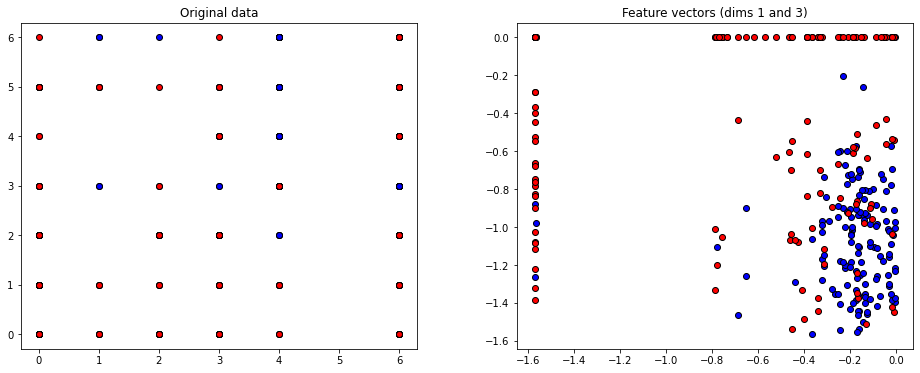

In [105]:
X = train_set[1:]

dim1 = 1
dim2 = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(6)
fig.subplots_adjust(hspace=0.25, wspace=0.25)

ax1.scatter(X[:, 1][Y == 1], X[:, 2][Y == 1], c="b", marker="o", edgecolors="k")
ax1.scatter(X[:, 1][Y == -1], X[:, 2][Y == -1], c="r", marker="o", edgecolors="k")
ax1.set_title("Original data")

ax2.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
ax2.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
ax2.set_title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

The data is split into training and validation sets, with 80% used for training and 20% for validation. 

In [106]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.8 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

We use 2 qubits and 6 layers for training, and initialize the weights and biases.

In [107]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

The Adam optimizer is used and the circuit is trained over 60 steps. The cost is seen to steadily decease, and the accuracy of the training and validation sets increases.

In [110]:
from pennylane.optimize import AdamOptimizer

opt = AdamOptimizer()
batch_size = 10

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    #print(feats_train_batch)
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4682579 | Acc train: 0.5250000 | Acc validation: 0.4333333 
Iter:     2 | Cost: 1.4147068 | Acc train: 0.5416667 | Acc validation: 0.4500000 
Iter:     3 | Cost: 1.3680681 | Acc train: 0.5458333 | Acc validation: 0.4666667 
Iter:     4 | Cost: 1.3231390 | Acc train: 0.5500000 | Acc validation: 0.4666667 
Iter:     5 | Cost: 1.2849768 | Acc train: 0.5500000 | Acc validation: 0.4833333 
Iter:     6 | Cost: 1.2497904 | Acc train: 0.5500000 | Acc validation: 0.4833333 
Iter:     7 | Cost: 1.2119336 | Acc train: 0.5541667 | Acc validation: 0.4833333 
Iter:     8 | Cost: 1.1709140 | Acc train: 0.5750000 | Acc validation: 0.5166667 
Iter:     9 | Cost: 1.1316815 | Acc train: 0.5875000 | Acc validation: 0.5166667 
Iter:    10 | Cost: 1.0926248 | Acc train: 0.6208333 | Acc validation: 0.5333333 
Iter:    11 | Cost: 1.0562716 | Acc train: 0.6375000 | Acc validation: 0.5500000 
Iter:    12 | Cost: 1.0231278 | Acc train: 0.6458333 | Acc validation: 0.5833333 
Iter:    13 | Co

Last the test set is prepared like our training set, and the accuracy is calculated:

In [111]:
# process our test data like we did our train data

# get the classical features in an array
test_set_classical_features = test_set[1:, 0:4]
print("First 3 classical features:\n", test_set_classical_features[0:3], "\n")

# normalize each input
norm = np.linalg.norm(test_set_classical_features)
test_set_norm = test_set_classical_features / norm
print("First 3 classical features (normalized):\n", test_set_norm[0:3], "\n")

# encode classical features as amplitudes
test_features = np.array([get_angles(x) for x in test_set_norm], requires_grad=False)
print("First 3 features:\n", test_features[0:3])

Y_test = test_set[1:, -1]

predictions_test = [np.sign(variational_classifier(weights, bias, f)) for f in test_features]
acc_test = accuracy(Y_test, predictions_test)
print("\nTesting accuracy: {}".format(acc_test))

First 3 classical features:
 [[2.98855 4.      4.      0.96593]
 [3.4138  0.      2.      1.     ]
 [3.89152 0.      0.      0.08716]] 

First 3 classical features (normalized):
 [[0.04514 0.06041 0.06041 0.01459]
 [0.05156 0.      0.03021 0.0151 ]
 [0.05878 0.      0.      0.00132]] 

First 3 features:
 [[ 1.37856 -0.23695  0.23695 -0.92913  0.92913]
 [ 1.15978 -0.46365  0.46365 -0.       0.     ]
 [ 0.04479 -1.57004  1.57004 -0.       0.     ]]

Testing accuracy: 0.975


The accuracy for the test set is found to be ~ 98%, demonstrating this model has good predictive power.

We will try one more run with a larger circuit:

In [112]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 2], W[1, 0], wires=0)
    qml.Rot(W[0, 1], W[0, 1], W[1, 2], wires=1)
    qml.Rot(W[1, 0], W[0, 1], W[1, 0], wires=1)
    qml.CNOT(wires=[1, 0])
    
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = AdamOptimizer()
batch_size = 10

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )
    

predictions_test = [np.sign(variational_classifier(weights, bias, f)) for f in test_features]
acc_test = accuracy(Y_test, predictions_test)
print("\nTesting accuracy: {}".format(acc_test))

Iter:     1 | Cost: 1.4549687 | Acc train: 0.5375000 | Acc validation: 0.4500000 
Iter:     2 | Cost: 1.4006231 | Acc train: 0.5458333 | Acc validation: 0.4666667 
Iter:     3 | Cost: 1.3631514 | Acc train: 0.5458333 | Acc validation: 0.4666667 
Iter:     4 | Cost: 1.3248408 | Acc train: 0.5500000 | Acc validation: 0.4666667 
Iter:     5 | Cost: 1.2818174 | Acc train: 0.5500000 | Acc validation: 0.4666667 
Iter:     6 | Cost: 1.2376712 | Acc train: 0.5458333 | Acc validation: 0.4833333 
Iter:     7 | Cost: 1.1943617 | Acc train: 0.5625000 | Acc validation: 0.5000000 
Iter:     8 | Cost: 1.1499421 | Acc train: 0.5708333 | Acc validation: 0.5000000 
Iter:     9 | Cost: 1.1060424 | Acc train: 0.5958333 | Acc validation: 0.5166667 
Iter:    10 | Cost: 1.0655589 | Acc train: 0.6125000 | Acc validation: 0.5500000 
Iter:    11 | Cost: 1.0272012 | Acc train: 0.6250000 | Acc validation: 0.5666667 
Iter:    12 | Cost: 0.9909132 | Acc train: 0.6458333 | Acc validation: 0.5833333 
Iter:    13 | Co

By the end of this run, the cost was slightly better than the last run, and the accuracy on the training and validation sets slightly worse. The accuracy on the test set was the same. Overall, the results were very similar, so making the circuit depth larger did not appear to be necessary.